In [1]:
# manipulacion de archivos
import os
import json
import warnings

# manipulacion y transformacion de datos
import numpy as np
print("numpy ==",np.__version__)
import pandas as pd
print("pandas ==",pd.__version__)

import geopandas as geopd
print("geopandas ==",geopd.__version__)

numpy == 1.26.0
pandas == 2.0.3
geopandas == 0.9.0


In [2]:
# modificar segun entorno local
os.chdir( "/Volumes/hd_mvf_datasets/henry_data")
folder_yelp = "yelp"
folder_us = "uscensus"
folder_zcta = "us_census2020_zcta520"

# no modificar
folder_data = "1_external"
folder_pipeline = "2_pipeline"
folder_output = "3_output"

In [3]:
business_df = pd.read_pickle(os.path.join(folder_data,folder_yelp, 'business.pkl')).convert_dtypes().iloc[:, :14]
business_df.info()
business_df.head(2)
print(business_df["business_id"].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  string 
 1   name          150346 non-null  string 
 2   address       150346 non-null  string 
 3   city          150346 non-null  string 
 4   state         150343 non-null  string 
 5   postal_code   150346 non-null  string 
 6   latitude      150346 non-null  Float64
 7   longitude     150346 non-null  Float64
 8   stars         150346 non-null  Float64
 9   review_count  150346 non-null  Int64  
 10  is_open       150346 non-null  Int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  string 
 13  hours         127123 non-null  object 
dtypes: Float64(3), Int64(2), object(2), string(7)
memory usage: 17.9+ MB
150346


In [4]:
business_df_usa = business_df[pd.to_numeric(business_df["postal_code"], errors="coerce").notnull()].copy()
print(round(len(business_df_usa) / len(business_df) * 100,2),"%")

96.26 %


In [5]:
geodata_zcta = geopd.read_file(
    os.path.join(folder_data,folder_us,folder_zcta,"tl_2020_us_zcta520.shp")).iloc[:,[1,5,9]]
geodata_zcta.rename(
    columns = {"GEOID20":"zcta5_geoid",
               "ALAND20":"zcta5_arealand"},
    inplace = True) 
geodata_zcta.info()
geodata_zcta.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33791 entries, 0 to 33790
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   zcta5_geoid     33791 non-null  object  
 1   zcta5_arealand  33791 non-null  int64   
 2   geometry        33791 non-null  geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 792.1+ KB


,zcta5_geoid,zcta5_arealand,geometry
0,35592,298552385,"POLYGON ((-88.24735 33.65390, -88.24713 33.654..."
1,35616,559506992,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,117838488,"POLYGON ((-86.81659 34.34960, -86.81649 34.349..."
3,35651,104521045,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,335675180,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."


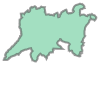

In [6]:
geodata_zcta["geometry"][0]

In [7]:
business_geodf = geopd.GeoDataFrame(
    business_df, geometry = geopd.points_from_xy(
        business_df.longitude, business_df.latitude),
    crs="EPSG:4326"
    ).to_crs(geodata_zcta.crs).iloc[:,[0,6,7,14]]
business_geodf.info()
business_geodf.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   business_id  150346 non-null  string  
 1   latitude     150346 non-null  Float64 
 2   longitude    150346 non-null  Float64 
 3   geometry     150346 non-null  geometry
dtypes: Float64(2), geometry(1), string(1)
memory usage: 6.0 MB


,business_id,latitude,longitude,geometry
0,Pns2l4eNsfO8kk83dixA6A,34.426679,-119.711197,POINT (-119.71119 34.42668)
1,mpf3x-BjTdTEA3yCZrAYPw,38.551126,-90.335695,POINT (-90.33569 38.55113)


In [8]:
business_geodf_zcta = geopd.sjoin(
    business_geodf,
    geodata_zcta,
    how="left"
    ,op="within"
    )
business_geodf_zcta.info()
business_geodf_zcta.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   business_id     150346 non-null  string  
 1   latitude        150346 non-null  Float64 
 2   longitude       150346 non-null  Float64 
 3   geometry        150346 non-null  geometry
 4   index_right     144750 non-null  float64 
 5   zcta5_geoid     144750 non-null  object  
 6   zcta5_arealand  144750 non-null  float64 
dtypes: Float64(2), float64(2), geometry(1), object(1), string(1)
memory usage: 9.5+ MB


,business_id,latitude,longitude,geometry,index_right,zcta5_geoid,zcta5_arealand
0,Pns2l4eNsfO8kk83dixA6A,34.426679,-119.711197,POINT (-119.71119 34.42668),31456.0,93101,8294077.0
1,mpf3x-BjTdTEA3yCZrAYPw,38.551126,-90.335695,POINT (-90.33569 38.55113),19731.0,63123,32255679.0
2,tUFrWirKiKi_TAnsVWINQQ,32.223236,-110.880452,POINT (-110.88045 32.22323),30323.0,85711,22316058.0
3,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,POINT (-75.15557 39.95550),16227.0,19107,1408994.0
4,mWMc6_wTdE0EUBKIGXDVfA,40.338183,-75.471659,POINT (-75.47166 40.33818),15901.0,18054,43881112.0


In [9]:
business_geodf_zcta_usa = business_geodf_zcta[business_geodf_zcta["zcta5_geoid"].notnull()].copy()
print(round(len(business_geodf_zcta_usa) / len(business_geodf_zcta) * 100,2),"%")

96.28 %


In [10]:
data_zcta_varsxarea = pd.read_csv(
    os.path.join(folder_output, 'data_zcta_varsxarea.csv'),
    dtype = {'zcta5_geoid': str})
data_zcta_varsxarea.info()
data_zcta_varsxarea.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46940 entries, 0 to 46939
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   zcta5_geoid             46940 non-null  object 
 1   zcta5_name              46940 non-null  object 
 2   pop_total               46940 non-null  int64  
 3   pop_m2f_ratio           46096 non-null  float64
 4   pop_age_median          46028 non-null  float64
 5   pop_foreign_prctng      46093 non-null  float64
 6   econ_income_median      43512 non-null  float64
 7   econ_housevalue_median  43214 non-null  float64
 8   econ_houserent_median   37983 non-null  float64
 9   pop_race2_prctng        46342 non-null  float64
 10  econ_unemp_prctng       46342 non-null  float64
 11  state_name              46940 non-null  object 
 12  state_usps              46940 non-null  object 
 13  county_name             46940 non-null  object 
dtypes: float64(8), int64(1), object(5)
mem

,zcta5_geoid,zcta5_name,pop_total,pop_m2f_ratio,pop_age_median,pop_foreign_prctng,econ_income_median,econ_housevalue_median,econ_houserent_median,pop_race2_prctng,econ_unemp_prctng,state_name,state_usps,county_name
0,00601,ZCTA5 00601,17126,97.4,43.7,NaN,15292.0,78800.0,377.0,5.185099,9.776595,puerto rico,PR,adjuntas municipio
1,00601,ZCTA5 00601,17126,97.4,43.7,NaN,15292.0,78800.0,377.0,5.185099,9.776595,puerto rico,PR,utuado municipio


In [11]:
business_geodf_zcta_census = pd.merge(
    business_geodf_zcta_usa,
    data_zcta_varsxarea,
    on="zcta5_geoid",
    how="left"
)
business_geodf_zcta_census.to_pickle(os.path.join(folder_pipeline, 'data_zcta_varsxarea.pkl'))
business_geodf_zcta_census.info()
business_geodf_zcta_census.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 166417 entries, 0 to 166416
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   business_id             166417 non-null  string  
 1   latitude                166417 non-null  Float64 
 2   longitude               166417 non-null  Float64 
 3   geometry                166417 non-null  geometry
 4   index_right             166417 non-null  float64 
 5   zcta5_geoid             166417 non-null  object  
 6   zcta5_arealand          166417 non-null  float64 
 7   zcta5_name              166417 non-null  object  
 8   pop_total               166417 non-null  int64   
 9   pop_m2f_ratio           166302 non-null  float64 
 10  pop_age_median          166309 non-null  float64 
 11  pop_foreign_prctng      166309 non-null  float64 
 12  econ_income_median      166114 non-null  float64 
 13  econ_housevalue_median  165990 non-null  float64 
 

,business_id,latitude,longitude,geometry,index_right,zcta5_geoid,zcta5_arealand,zcta5_name,pop_total,pop_m2f_ratio,pop_age_median,pop_foreign_prctng,econ_income_median,econ_housevalue_median,econ_houserent_median,pop_race2_prctng,econ_unemp_prctng,state_name,state_usps,county_name
0,Pns2l4eNsfO8kk83dixA6A,34.426679,-119.711197,POINT (-119.71119 34.42668),31456.0,93101,8294077.0,ZCTA5 93101,31439,106.7,32.5,26.0,67368.0,905500.0,1816.0,14.179840,3.118535,california,CA,santa barbara county
1,mpf3x-BjTdTEA3yCZrAYPw,38.551126,-90.335695,POINT (-90.33569 38.55113),19731.0,63123,32255679.0,ZCTA5 63123,49886,96.1,40.7,10.6,65693.0,166300.0,887.0,4.349918,2.567020,missouri,MO,st. louis county
2,mpf3x-BjTdTEA3yCZrAYPw,38.551126,-90.335695,POINT (-90.33569 38.55113),19731.0,63123,32255679.0,ZCTA5 63123,49886,96.1,40.7,10.6,65693.0,166300.0,887.0,4.349918,2.567020,missouri,MO,st. louis city
3,tUFrWirKiKi_TAnsVWINQQ,32.223236,-110.880452,POINT (-110.88045 32.22323),30323.0,85711,22316058.0,ZCTA5 85711,41369,92.8,36.1,11.5,45984.0,181600.0,866.0,13.802606,3.945878,arizona,AZ,pima county
4,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,POINT (-75.15557 39.95550),16227.0,19107,1408994.0,ZCTA5 19107,14984,92.7,31.4,23.0,62280.0,412300.0,1429.0,6.687133,3.144080,pennsylvania,PA,philadelphia county
